In [ ]:
!nvidia-smi

Mon Feb 16 13:30:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzips your file quietly (-q) into Colab's local /content/ folder
!unzip -q "/content/drive/MyDrive/BRISC2025.zip" -d "/content/brisc_dataset"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [ ]:
# Define how to process the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # Flips 50% of images like a mirror
    transforms.RandomRotation(degrees=15),  # Tilts the brain up to 15 degrees
    transforms.ToTensor(),
])

# Map 'no_tumor' (index 2) to 0, and all other tumors to 1
binary_transform = lambda target: 0 if target == 2 else 1

# Load dataset (make sure this path matches how your zip file is structured inside)
dataset = datasets.ImageFolder(
    root='/content/brisc_dataset/brisc2025/classification_task/train',
    transform=transform,
    target_transform=binary_transform
)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Move computations to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet18 model and change the last layer for binary output (1 node)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Epoch 1/15 | Train Loss: 0.1556 | Val Loss: 0.1851 | Train Acc: 96.14% | Val Acc: 97.40%
Epoch 2/15 | Train Loss: 0.1548 | Val Loss: 0.1910 | Train Acc: 96.26% | Val Acc: 97.50%
Epoch 3/15 | Train Loss: 0.1564 | Val Loss: 0.1591 | Train Acc: 96.14% | Val Acc: 97.60%
Epoch 4/15 | Train Loss: 0.1490 | Val Loss: 0.1943 | Train Acc: 96.14% | Val Acc: 97.80%
Epoch 5/15 | Train Loss: 0.1628 | Val Loss: 0.1296 | Train Acc: 96.16% | Val Acc: 98.20%
Epoch 6/15 | Train Loss: 0.1514 | Val Loss: 0.1865 | Train Acc: 96.00% | Val Acc: 97.80%
Epoch 7/15 | Train Loss: 0.1583 | Val Loss: 0.1803 | Train Acc: 96.36% | Val Acc: 97.50%
Epoch 8/15 | Train Loss: 0.1626 | Val Loss: 0.1623 | Train Acc: 96.08% | Val Acc: 97.60%
Epoch 9/15 | Train Loss: 0.1486 | Val Loss: 0.1601 | Train Acc: 96.04% | Val Acc: 98.00%
Epoch 10/15 | Train Loss: 0.1604 | Val Loss: 0.1858 | Train Acc: 96.06% | Val Acc: 97.80%
Epoch 11/15 | Train Loss: 0.1516 | Val Loss: 0.1768 | Train Acc: 96.08% | Val Acc: 97.60%
Epoch 12/15 | Train

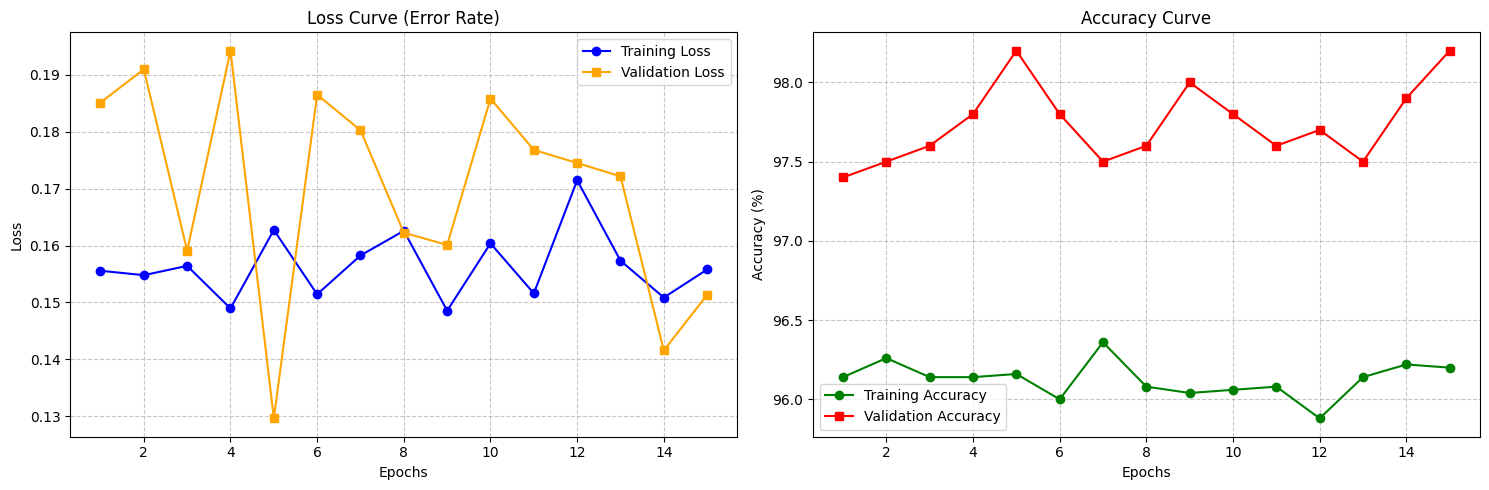

In [ ]:
import matplotlib.pyplot as plt
import torch

# Lists to store metrics for our graphs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 15

for epoch in range(epochs):
    # ==========================
    #      TRAINING PHASE
    # ==========================
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Accuracy math
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_acc = (train_correct / train_total) * 100

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ==========================
    #     VALIDATION PHASE
    # ==========================
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader: # We use test_loader as our validation set
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Accuracy math
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(test_loader)
    val_acc = (val_correct / val_total) * 100

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    # THE EXACT OUTPUT YOUR GUIDE WANTS
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# ==========================
#  PLOTTING THE TWO GRAPHS
# ==========================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graph 1: Loss
ax1.plot(range(1, epochs+1), train_losses, label='Training Loss', color='blue', marker='o')
ax1.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='orange', marker='s')
ax1.set_title('Loss Curve (Error Rate)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Graph 2: Accuracy
ax2.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', color='green', marker='o')
ax2.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='red', marker='s')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 1. Load the Test Data (using the same transforms as before)
test_dataset = datasets.ImageFolder(
    root='/content/brisc_dataset/brisc2025/classification_task/test',
    transform=transform,
    target_transform=binary_transform
)
# shuffle=False is important here so we can match predictions to the right labels
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Run the Evaluation Loop
model.eval() # Put the model in evaluation mode (turns off dropout, etc.)
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad(): # Turn off gradient tracking to save memory and compute
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)    # Convert raw logits to probabilities (0.0 to 1.0)
        preds = (probs >= 0.3).float()    # Threshold at 0.5 to decide Tumor (1) or No Tumor (0)

        # Save batches to our master lists
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Calculate Core Metrics
accuracy = accuracy_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds) # In medicine, Recall is called Sensitivity
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

# 4. Extract Specificity from the Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

# 5. Print the Results
print(f"Accuracy:    {accuracy * 100:.2f}%")
print(f"Sensitivity: {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC-ROC:     {auc:.4f}")

Accuracy:    98.10%
Sensitivity: 99.07%
Specificity: 92.14%
F1-Score:    0.9890
AUC-ROC:     0.9929


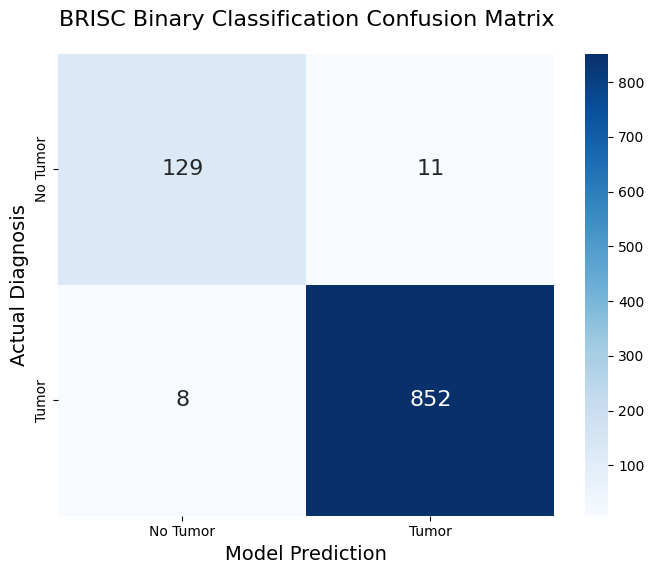

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Set up the visual plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            annot_kws={"size": 16}) # Makes the numbers larger

# Add labels and a title
plt.ylabel('Actual Diagnosis', fontsize=14)
plt.xlabel('Model Prediction', fontsize=14)
plt.title('BRISC Binary Classification Confusion Matrix', fontsize=16, pad=20)
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/my_brisc_binary_model.pth')